In [1]:
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers "trl<0.9.0" peft accelerate bitsandbytes

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-rvx7roum/unsloth_1da7ff77a5234ed88f8b268c0e57d9de
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-rvx7roum/unsloth_1da7ff77a5234ed88f8b268c0e57d9de
  Resolved https://github.com/unslothai/unsloth.git to commit 8d9bd0ea8bf662618ba96fe7fe3478c5b81d0dff
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [66]:
!pip install -U scikit-learn

In [19]:
!pip install tensorboard

In [1]:
from unsloth import FastLanguageModel
import torch
import os
import json
from datasets import load_dataset, Dataset
from transformers import TrainingArguments
from trl import SFTTrainer
from unsloth.chat_templates import get_chat_template
from transformers import TextStreamer
import requests
from transformers import TextStreamer
from unsloth.chat_templates import get_chat_template
import random
from datasets import load_metric
from sklearn.model_selection import train_test_split
from transformers.integrations import TensorBoardCallback

/home/vatsal-patel/anaconda3/envs/unsloth_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [2]:
# Settings
max_seq_length = 512 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

In [3]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Phi-3-mini-4k-instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth: Fast Mistral patching release 2024.5
   \\   /|    GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU. Max memory: 3.811 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0. CUDA = 8.6. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [4]:
from datasets import Dataset, DatasetDict
import random
dataset_path = 'data/weather_chatbot_dataset.json'
with open(dataset_path, 'r') as f:
    weather_data = json.load(f)

In [5]:
weather_data[0]

{'user_input': 'What is the current weather in Frankfurt today?',
 'intent_extraction': {'intent': 'current_weather',
  'entities': {'city': 'Frankfurt', 'date': 'today'}},
 'api_response': {'location': 'Frankfurt, DE',
  'temperature': 12.76,
  'description': 'clear sky',
  'wind_speed': 7.2,
  'humidity': 62},
 'assistant_response': 'The weather in Frankfurt is currently clear sky with a temperature of 12.76°C, wind speed of 7.2 meters per second, and humidity of 62%.'}

In [6]:
# Split the dataset
intent_identification_data = []
assistant_response_data = []

for entry in weather_data:
    # For intent identification
    intent_identification_data.append({
        "user_input": entry["user_input"],
        "intent_extraction": entry["intent_extraction"]
    })
    
    # For assistant response generation
    assistant_response_data.append({
        "user_input": entry["user_input"],
        "api_response": entry["api_response"],
        "assistant_response": entry["assistant_response"]
    })

# Combine the datasets
combined_data = intent_identification_data + assistant_response_data

# Shuffle the combined dataset
random.shuffle(combined_data)
# train_test_split

# Convert to Hugging Face Dataset format
combined_dataset = Dataset.from_dict({"conversations": combined_data})

In [7]:
dataset_split = combined_dataset.train_test_split(test_size=0.3)  
train_dataset = dataset_split['train']
val_dataset = dataset_split['test']

In [10]:
train_dataset[0]

{'conversations': {'api_response': None,
  'assistant_response': None,
  'intent_extraction': {'entities': {'city': 'Santiago', 'date': '2024-06-15'},
   'intent': 'forecast_weather'},
  'user_input': 'What is the forecast weather in Santiago 2024-06-15?'}}

In [11]:
train_dataset[1]

{'conversations': {'api_response': {'date': '2024-06-14',
   'description': 'overcast clouds',
   'humidity': 79,
   'location': None,
   'temperature': 11.09,
   'wind_speed': 2.99},
  'assistant_response': 'The forecast for Hamburg on 2024-06-14 is overcast clouds with a temperature of 11.09°C, wind speed of 2.99 meters per second, and humidity of 79%.',
  'intent_extraction': None,
  'user_input': 'What is the forecast weather in Helsinki 2024-06-12?'}}

In [10]:
# from datasets import train_test_split

In [11]:
# dataset_dict['intent_identification'][0]

In [12]:
# dataset_dict['assistant_response'][0]

In [13]:
from unsloth.chat_templates import get_chat_template
from typing import Dict, List

tokenizer = get_chat_template(
    tokenizer,
    chat_template="phi-3",
    mapping={"role": "from", "content": "value", "user": "human", "assistant": "gpt", "API": "api"},
)

def format_combined_prompts(batch: Dict[str, List[Dict]], tokenizer):
    def format_conversation(example: Dict[str, str]):
        conversation = [{"from": "human", "value": example['user_input']}]
        if "intent_extraction" in example and example['intent_extraction'] is not None:
            conversation.append({"from": "gpt", "value": str(example['intent_extraction'])})
        if "api_response" in example and example['api_response'] is not None:
            conversation.append({"from": "api", "value": str(example['api_response'])})
            if "assistant_response" in example and example['assistant_response'] is not None:
                conversation.append({"from": "gpt", "value": example['assistant_response']})
        return conversation

    texts = [tokenizer.apply_chat_template(format_conversation(example), tokenize=False, add_generation_prompt=True) for example in batch["conversations"]]
    return {"text": texts}

# Apply formatting
train_dataset = train_dataset.map(lambda batch: format_combined_prompts(batch, tokenizer), batched=True)
val_dataset = val_dataset.map(lambda batch: format_combined_prompts(batch, tokenizer), batched=True)


Map: 100%|██████████████████████████| 399/399 [00:00<00:00, 22049.98 examples/s]


In [14]:
train_dataset[0]

{'conversations': {'api_response': {'date': '2024-06-15',
   'description': 'scattered clouds',
   'humidity': 82,
   'location': None,
   'temperature': 17.95,
   'wind_speed': 3.23},
  'assistant_response': 'The forecast for Marseille on 2024-06-15 is scattered clouds with a temperature of 17.95°C, wind speed of 3.23 meters per second, and humidity of 82%.',
  'intent_extraction': None,
  'user_input': 'What is the current weather in Casablanca today?'},
 'text': "<s><|user|>\nWhat is the current weather in Casablanca today?<|end|>\n<|api|>\n{'date': '2024-06-15', 'description': 'scattered clouds', 'humidity': 82, 'location': None, 'temperature': 17.95, 'wind_speed': 3.23}<|end|>\n<|assistant|>\nThe forecast for Marseille on 2024-06-15 is scattered clouds with a temperature of 17.95°C, wind speed of 3.23 meters per second, and humidity of 82%.<|end|>\n<|assistant|>\n"}

In [15]:
train_dataset[1]

{'conversations': {'api_response': None,
  'assistant_response': None,
  'intent_extraction': {'entities': {'city': 'Sendai', 'date': '2024-06-14'},
   'intent': 'forecast_weather'},
  'user_input': 'What is the forecast weather in Sendai 2024-06-14?'},
 'text': "<s><|user|>\nWhat is the forecast weather in Sendai 2024-06-14?<|end|>\n<|assistant|>\n{'entities': {'city': 'Sendai', 'date': '2024-06-14'}, 'intent': 'forecast_weather'}<|end|>\n<|assistant|>\n"}

In [16]:
# Modify global metric lists to include validation split
train_metrics = {"step": [], "bleu": [], "rouge": [], "perplexity": []}
val_metrics = {"step": [], "bleu": [], "rouge": [], "perplexity": []}

def compute_metrics(eval_pred, split="train"):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # BLEU
    bleu = load_metric("bleu")
    bleu_result = bleu.compute(predictions=decoded_preds, references=decoded_labels)

    # ROUGE
    rouge = load_metric("rouge")
    rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels)

    # Perplexity
    perplexity = torch.exp(torch.tensor(eval_pred[0].mean()))

    metrics = {
        "bleu": bleu_result['bleu'],
        "rouge": rouge_result['rougeL'].mid.fmeasure,
        "perplexity": perplexity.item(),
    }

    if split == "train":
        train_metrics["step"].append(len(train_metrics["step"]) + 1)
        train_metrics["bleu"].append(metrics["bleu"])
        train_metrics["rouge"].append(metrics["rouge"])
        train_metrics["perplexity"].append(metrics["perplexity"])
    else:
        val_metrics["step"].append(len(val_metrics["step"]) + 1)
        val_metrics["bleu"].append(metrics["bleu"])
        val_metrics["rouge"].append(metrics["rouge"])
        val_metrics["perplexity"].append(metrics["perplexity"])

    return metrics


In [17]:
# Training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    warmup_steps=5,
    max_steps=60,
    learning_rate=2e-4,
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    logging_steps=1,
    optim="adamw_8bit",
    weight_decay=0.01,
    lr_scheduler_type="linear",
    seed=3407,
    output_dir="outputs_combined",
    logging_dir='./logs',
    report_to="tensorboard",
)

In [30]:
# train_metrics

In [18]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,
    args=training_args,
    compute_metrics=lambda eval_pred: compute_metrics(eval_pred, split="train"),
)

Map (num_proc=2): 100%|██████████████| 399/399 [00:00<00:00, 1731.77 examples/s]
max_steps is given, it will override any value given in num_train_epochs


In [19]:
# Add TensorBoard callback
trainer.add_callback(TensorBoardCallback)

You are adding a <class 'transformers.integrations.integration_utils.TensorBoardCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback
NotebookProgressCallback


In [20]:
# Train the model
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 929 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 29,884,416


Step,Training Loss
1,3.060500
2,3.021500
3,2.975400
4,2.749100
5,2.601900
6,2.275100
7,1.820400
8,1.716200
9,1.418300
10,1.181100


In [34]:
torch.cuda.empty_cache() 

In [35]:
trainer.evaluate()

OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 MiB. GPU 

In [24]:
# val_results = trainer.evaluate(eval_dataset=val_dataset, metric_key_prefix="val")

In [25]:
model.push_to_hub("VatsalPatel18/phi3-mini-WeatherBot", token=os.getenv("HUGGINGFACE_HUB_TOKEN"))

Saved model to https://huggingface.co/VatsalPatel18/phi3-mini-WeatherBot


In [26]:
model.save_pretrained("../models/trained")
tokenizer.save_pretrained("../models/trained")

('../models/trained/tokenizer_config.json',
 '../models/trained/special_tokens_map.json',
 '../models/trained/tokenizer.model',
 '../models/trained/added_tokens.json',
 '../models/trained/tokenizer.json')

In [27]:
# !pip install matplotlib

In [38]:
model.save_pretrained_gguf("../models/gguf/", tokenizer, quantization_method = "q4_k_m")

Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 6.05 out of 14.96 RAM for saving.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.37it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 5 minutes for Llama-7b...
Done.


Unsloth: ##### The current model type of mistral auto adds a BOS token.
Unsloth: ##### If you're using Ollama or GGUF etc, do not add a BOS in the chat template.
Unsloth: Extending ../models/gguf//tokenizer.model with added_tokens.json.
Originally tokenizer.model is of size (32000).
But we need to extend to sentencepiece vocab size (32011).


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp will take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GUUF 16bits will take 3 minutes.
\        /    [2] Converting GGUF 16bits to q4_k_m will take 20 minutes.
 "-____-"     In total, you will have to wait around 26 minutes.

Unsloth: [0] Installing llama.cpp. This will take 3 minutes...
Unsloth: [1] Converting model at ../models/gguf/ into f16 GGUF format.
The output location will be ./../models/gguf/-unsloth.F16.gguf
This will take 3 minutes...
INFO:hf-to-gguf:Loading model: gguf
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Set model parameters
INFO:hf-to-gguf:gguf: context length = 4096
INFO:hf-to-gguf:gguf: embedding length = 3072
INFO:hf-to-gguf:gguf: feed forward length = 8192
INFO:hf-to-gguf:gguf: head count = 32
INFO:hf-to-gguf:gguf: key-value head count = 32
INFO:hf-to-gguf:gguf: rope theta = 10000.0
INFO:hf-to-gguf:gguf: rms norm ep

Unsloth: ##### The current model type of mistral auto adds a BOS token.
Unsloth: ##### If you're using Ollama or GGUF etc, do not add a BOS in the chat template.


Unsloth: Conversion completed! Output location: ./../models/gguf/-unsloth.Q4_K_M.gguf


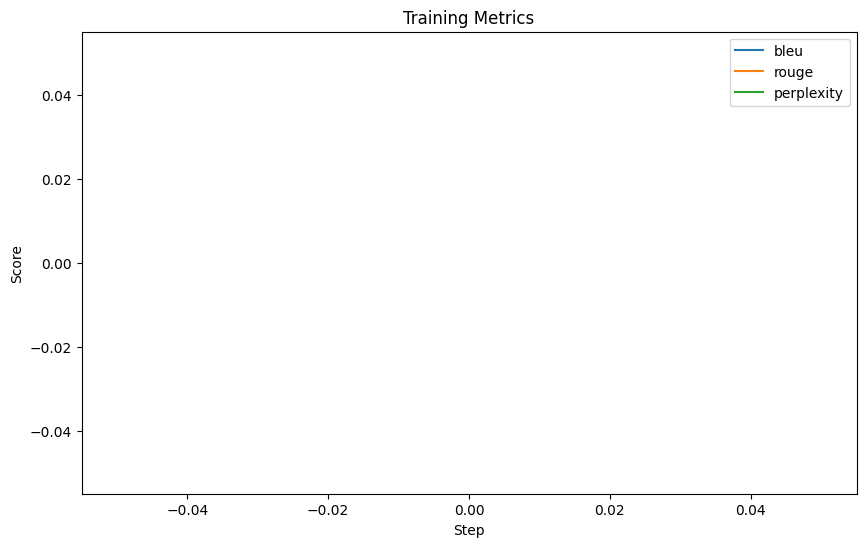

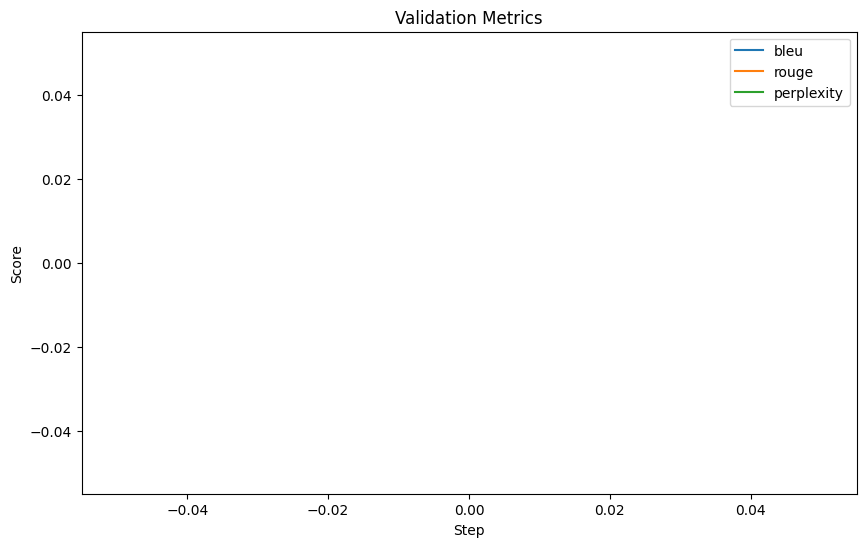

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics(metrics, title, ylabel):
    df = pd.DataFrame(metrics)
    plt.figure(figsize=(10, 6))
    for column in metrics:
        if column != "step":
            plt.plot(df["step"], df[column], label=column)
    plt.xlabel("Step")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Plotting training metrics
plot_metrics(train_metrics, "Training Metrics", "Score")

# Plotting validation metrics
plot_metrics(val_metrics, "Validation Metrics", "Score")



In [29]:
# from unsloth import FastLanguageModel

# model = FastLanguageModel.from_pretrained("path/to/save/model")
# tokenizer = AutoTokenizer.from_pretrained("path/to/save/tokenizer")
